<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Quite Complex Portfolios 

This part illustrates that you can **model, value and risk manage quite complex derivatives portfolios** with DX Analytics.

In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
from dx import *
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
np.random.seed(10000)

## Multiple Risk Factors

The example is based on a **multiple, correlated risk factors**, all (for the ease of exposition) `geometric_brownian_motion` objects.

In [3]:
mer = market_environment(name='me', pricing_date=dt.datetime(2015, 1, 1))
mer.add_constant('initial_value', 0.01)
mer.add_constant('volatility', 0.1)
mer.add_constant('kappa', 2.0)
mer.add_constant('theta', 0.05)
mer.add_constant('paths', 100) # dummy
mer.add_constant('frequency', 'M') # dummy
mer.add_constant('starting_date', mer.pricing_date)
mer.add_constant('final_date', dt.datetime(2015, 12, 31)) # dummy
ssr = stochastic_short_rate('ssr', mer)

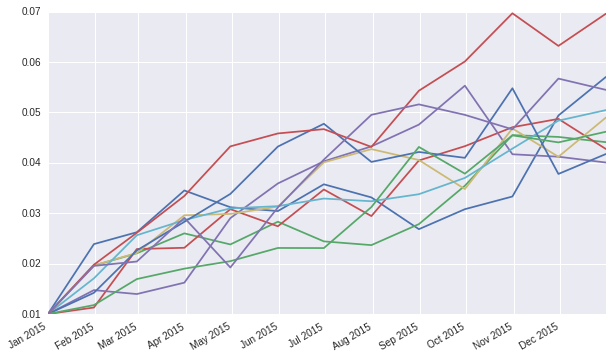

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(ssr.process.time_grid, ssr.process.get_instrument_values()[:, :10]);
plt.gcf().autofmt_xdate()

In [5]:
# market environments
me = market_environment('gbm', dt.datetime(2015, 1, 1))

In [6]:
# geometric Brownian motion
me.add_constant('initial_value', 36.)
me.add_constant('volatility', 0.2) 
me.add_constant('currency', 'EUR')

In [7]:
# jump diffusion
me.add_constant('lambda', 0.4)
me.add_constant('mu', -0.4) 
me.add_constant('delta', 0.2)

In [8]:
# stochastic volatility
me.add_constant('kappa', 2.0)
me.add_constant('theta', 0.3) 
me.add_constant('vol_vol', 0.5)
me.add_constant('rho', -0.5)

Using 2,500 paths and monthly discretization for the example.

In [9]:
# valuation environment
val_env = market_environment('val_env', dt.datetime(2015, 1, 1))
val_env.add_constant('paths', 1000)
val_env.add_constant('frequency', 'M')
val_env.add_curve('discount_curve', ssr)
val_env.add_constant('starting_date', dt.datetime(2015, 1, 1))
val_env.add_constant('final_date', dt.datetime(2016, 12, 31))

In [10]:
# add valuation environment to market environments
me.add_environment(val_env)

In [11]:
no = 50  # 50 different risk factors in total

In [12]:
risk_factors = {}
for rf in range(no):
    # random model choice
    sm = np.random.choice(['gbm', 'jd', 'sv'])
    key = '%3d_%s' % (rf + 1, sm)
    risk_factors[key] = market_environment(key, me.pricing_date)
    risk_factors[key].add_environment(me)
    # random initial_value
    risk_factors[key].add_constant('initial_value',
                                    np.random.random() * 40. + 20.)
    # radnom volatility
    risk_factors[key].add_constant('volatility',
                                    np.random.random() * 0.6 + 0.05)
    # the simulation model to choose
    risk_factors[key].add_constant('model', sm)

In [13]:
correlations = []
keys = sorted(risk_factors.keys())
for key in keys[1:]:
    correlations.append([keys[0], key, np.random.choice([-0.1, 0.0, 0.1])])
correlations[:3]

[['  1_sv', '  2_gbm', 0.10000000000000001],
 ['  1_sv', '  3_gbm', -0.10000000000000001],
 ['  1_sv', '  4_gbm', -0.10000000000000001]]

## Options Modeling

We model a certain number of **derivative instruments** with the following major assumptions.

In [14]:
me_option = market_environment('option', me.pricing_date)
# choose from a set of maturity dates (month ends)
maturities = pd.date_range(start=me.pricing_date,
                           end=val_env.get_constant('final_date'),
                           freq='M').to_pydatetime()
me_option.add_constant('maturity', np.random.choice(maturities))
me_option.add_constant('currency', 'EUR')
me_option.add_environment(val_env)

## Portfolio Modeling

The `derivatives_portfolio` object we compose consists of **multiple derivatives positions**. Each option differs with respect to the strike and the risk factor it is dependent on.

In [15]:
# 5 times the number of risk factors
# as portfolio positions/instruments
pos = 5 * no              

In [16]:
positions = {}
for i in range(pos):
    ot = np.random.choice(['am_put', 'eur_call'])
    if ot == 'am_put':
        otype = 'American single'
        payoff_func = 'np.maximum(%5.3f - instrument_values, 0)'
    else:
        otype = 'European single'
        payoff_func = 'np.maximum(maturity_value - %5.3f, 0)'
    # random strike
    strike = np.random.randint(36, 40)
    underlying = sorted(risk_factors.keys())[(i + no) % no]
    name = '%d_option_pos_%d' % (i, strike)
    positions[name] = derivatives_position(
                        name=name,
                        quantity=np.random.randint(1, 10),
                        underlyings=[underlying],
                        mar_env=me_option,
                        otype=otype,
        payoff_func=payoff_func % strike)

In [17]:
# number of derivatives positions
len(positions)

250

## Portfolio Valuation

First, the derivatives portfolio with **sequential valuation**.

In [18]:
port = derivatives_portfolio(
                name='portfolio',
                positions=positions,
                val_env=val_env,
                risk_factors=risk_factors,
                correlations=correlations,
                parallel=False)  # sequential calculation

In [19]:
port.val_env.get_list('cholesky_matrix')

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1       ,  0.99498744,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.1       ,  0.01005038,  0.99493668, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-0.1       ,  0.01005038, -0.01015242, ...,  0.99239533,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.1       , -0.01005038,  0.01015242, ...,  0.01526762,
         0.        ,  0.99227788]])

The call of the `get_values` method to **value all instruments**.

In [20]:
%time res = port.get_statistics(fixed_seed=True)

Totals
pos_value    10400.2920
pos_delta      116.0584
pos_vega      8477.9800
dtype: float64
CPU times: user 1min 31s, sys: 4min 11s, total: 5min 43s
Wall time: 46.4 s


In [21]:
res.set_index('position', inplace=False)

,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
position,,,,,,,,,
94_option_pos_38,94_option_pos_38,9,European single,[ 45_sv],11.609,EUR,104.481,6.4827,30.2337
184_option_pos_37,184_option_pos_37,3,American single,[ 35_jd],2.778,EUR,8.334,-0.3153,32.9244
187_option_pos_36,187_option_pos_36,1,European single,[ 38_gbm],0.032,EUR,0.032,0.0187,1.1225
181_option_pos_38,181_option_pos_38,6,European single,[ 32_jd],9.795,EUR,58.770,4.4466,46.5300
22_option_pos_38,22_option_pos_38,8,American single,[ 23_jd],1.238,EUR,9.904,-0.3840,62.1928
103_option_pos_36,103_option_pos_36,2,European single,[ 4_gbm],0.060,EUR,0.120,0.1202,6.6230
201_option_pos_38,201_option_pos_38,3,American single,[ 2_gbm],4.832,EUR,14.496,-0.7197,59.5605
144_option_pos_39,144_option_pos_39,9,European single,[ 45_sv],11.102,EUR,99.918,6.3576,30.9024
203_option_pos_38,203_option_pos_38,5,European single,[ 4_gbm],0.013,EUR,0.065,0.1085,7.3415


## Risk Analysis

**Full distribution of portfolio present values** illustrated via histogram.

In [22]:
%time pvs = port.get_present_values()

CPU times: user 23.9 s, sys: 59.8 s, total: 1min 23s
Wall time: 11.1 s


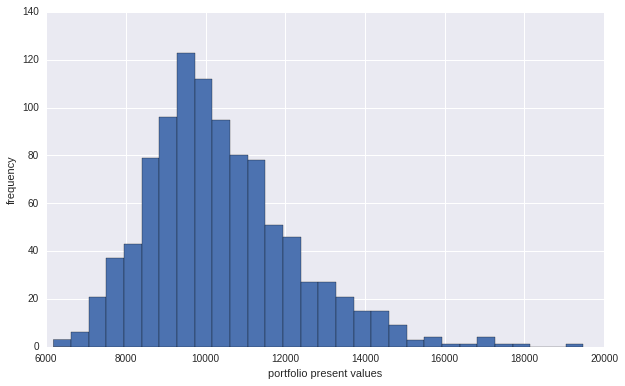

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(pvs, bins=30);
plt.xlabel('portfolio present values')
plt.ylabel('frequency')

Some **statistics** via pandas.

In [24]:
pdf = pd.DataFrame(pvs)
pdf.describe()

,0
count,1000.000000
mean,10372.508708
std,1838.009674
min,6182.811952
25%,9132.210097
50%,10074.925093
75%,11354.272518
max,19482.511818


The **delta** risk report.

In [25]:
%%time
deltas, benchmark = port.get_port_risk(Greek='Delta', fixed_seed=True, step=0.2,
                                       risk_factors=risk_factors.keys()[:4])
risk_report(deltas)


 19_gbm
0.8 1.0 1.2 
 24_jd
0.8 1.0 1.2 
 30_gbm
0.8 1.0 1.2 
 20_jd
0.8 1.0 1.2 



 19_gbm_Delta
             0.8       1.0       1.2
factor     37.70     47.12     56.54
value   10288.64  10372.50  10490.73

 20_jd_Delta
             0.8      1.0       1.2
factor     18.88     23.6     28.32
value   10447.71  10372.5  10298.97

 24_jd_Delta
             0.8       1.0       1.2
factor     18.75     23.43     28.12
value   10447.08  10372.50  10320.61

 30_gbm_Delta
             0.8      1.0       1.2
factor     32.72     40.9     49.08
value   10299.01  10372.5  10459.88
CPU times: user 29.6 s, sys: 1min 19s, total: 1min 49s
Wall time: 14.9 s


The **vega** risk report.

In [26]:
%%time
vegas, benchmark = port.get_port_risk(Greek='Vega', fixed_seed=True, step=0.2,
                                      risk_factors=risk_factors.keys()[:3])
risk_report(vegas)


 19_gbm
0.8 1.0 1.2 
 24_jd
0.8 1.0 1.2 
 30_gbm
0.8 1.0 1.2 



 19_gbm_Vega
             0.8       1.0       1.2
factor      0.52      0.65      0.78
value   10301.43  10373.17  10445.49

 24_jd_Vega
             0.8       1.0       1.2
factor      0.49      0.62      0.74
value   10340.30  10373.17  10415.43

 30_gbm_Vega
             0.8       1.0       1.2
factor      0.52      0.65      0.78
value   10336.92  10373.17  10407.77
CPU times: user 27.4 s, sys: 1min 8s, total: 1min 36s
Wall time: 12.8 s


## Visualization of Results

Selected **results visualized**.

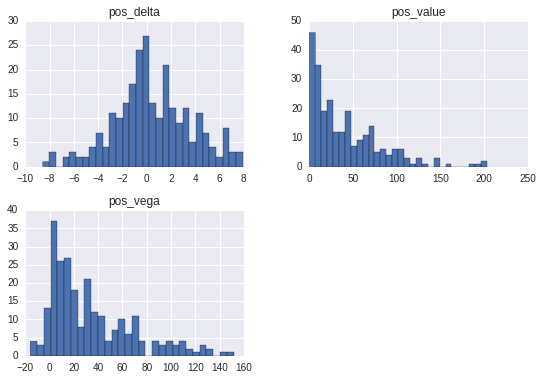

In [27]:
res[['pos_value', 'pos_delta', 'pos_vega']].hist(bins=30, figsize=(9, 6))
plt.ylabel('frequency')

**Sample paths** for three underlyings.

In [28]:
paths_0 = port.underlying_objects.values()[0]
paths_0.generate_paths()
paths_1 = port.underlying_objects.values()[1]
paths_1.generate_paths()
paths_2 = port.underlying_objects.values()[2]
paths_2.generate_paths()

Paths for  19_gbm (blue)
Paths for  24_jd (red)
Paths for  30_gbm (green)


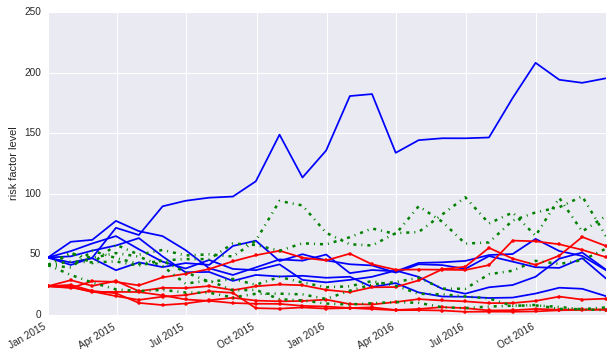

In [29]:
pa = 5
plt.figure(figsize=(10, 6))
plt.plot(port.time_grid, paths_0.instrument_values[:, :pa], 'b');
print 'Paths for %s (blue)' % paths_0.name
plt.plot(port.time_grid, paths_1.instrument_values[:, :pa], 'r.-');
print 'Paths for %s (red)' % paths_1.name
plt.plot(port.time_grid, paths_2.instrument_values[:, :pa], 'g-.', lw=2.5);
print 'Paths for %s (green)' % paths_2.name
plt.ylabel('risk factor level')
plt.gcf().autofmt_xdate()

**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)